<img src="https://raw.githubusercontent.com/DHI/mikepluspy/main/images/logo/mikeplus-py.svg" alt="image" width="400">

# Example - Run and modify MIKE+ models

#### Run MIKE+ model

In [1]:
from mikeplus import DataTableAccess
from mikeplus.engines import Engine1D

In [2]:
# Open MIKE+ database

dta = DataTableAccess("data/simple_model.sqlite")
dta.open_database()
dta

<DataTableContainer>
Db major version: 2025
Db minor version: 0.0
Active model: CS_MIKE1D
Unit system: MU_CS_SI
Active simulation: my_simulation

In [3]:
# Run simulation

engine = Engine1D(dta.datatables)
engine.run(verbose=True)

Simulation is started. Simulation id is 'my_simulation'.
2024-12-12 09:21:34: MIKE 1D Engine started (2025 - 64 bit, .NETFramework,Version=v4.7.2 (.NET Framework 4.8.9282.0))

                     Version of MIKE 1D                            : 23 (23.0.3.18318, 2024-11-13)

                     Version of DHI.Mike1D.Engine                  : 23 (23.0.3.18318, 2024-11-13 18:56:27)

                     Version of DHI.Mike1D.RainfallRunoffModule    : 23 (23.0.3.18318, 2024-11-13 19:01:42)

2024-12-12 09:21:37: Loading setup file simple_model.sqlite...

2024-12-12 09:21:40: Loading finished

2024-12-12 09:21:40: Simulation ID is my_simulation

2024-12-12 09:21:40: Scenario ID is Base

2024-12-12 09:21:40: Validating setup

2024-12-12 09:21:40: Initializing Setup

2024-12-12 09:21:41: Diagnostics messages during Initialize phase:

2024-12-12 09:21:41: WARNING: Hyper Threading is enabled, or system is highly utilized. Setting number of threads to half of maximum (6 of 12) (DA_WAR_HyperThre

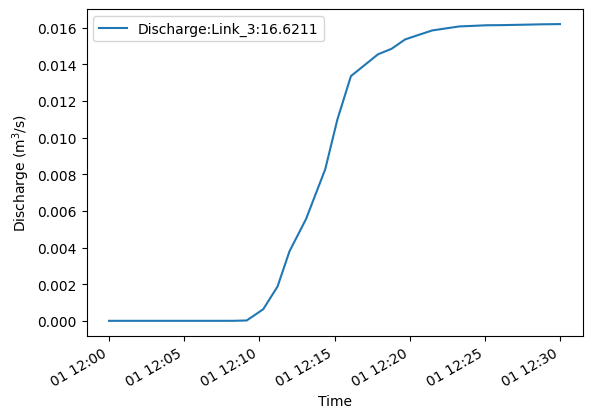

In [4]:
# Plot discharge of last pipe

from mikeio1d import Res1D

res = Res1D("data/my_simulationBaseDefault_Network_HD.res1d")
res.reaches['Link_3'].Discharge.plot();

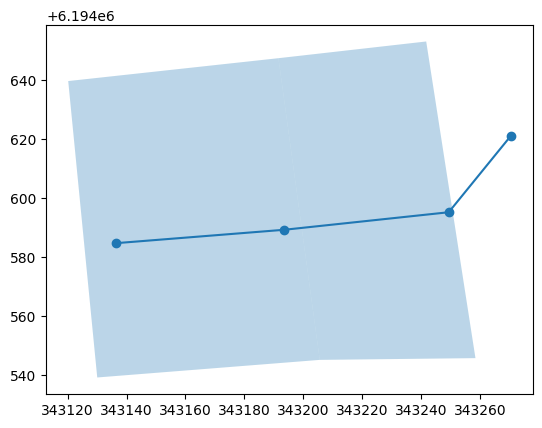

In [5]:
# Plot network for context

res_catch = Res1D("data/my_simulationBaseDefault_Surface_runoff.res1d")
ax = res.network.to_geopandas().plot()
res_catch.network.to_geopandas().plot(ax=ax, alpha=0.3);

#### Modify MIKE+ model

In [6]:
# Update constant rainfall value from 5 mm/hr to 100 mm/hr

dta.set_value(
    table_name = 'msm_BBoundary',
    column = 'ConstantValue',
    muid = 'Rainfall',
    value = 100 / 1000 / 3600 # mm/hr as m/s
)

In [7]:
# Run model again

engine.run(verbose=True)

Simulation is started. Simulation id is 'my_simulation'.
2024-12-12 09:25:02: MIKE 1D Engine started (2025 - 64 bit, .NETFramework,Version=v4.7.2 (.NET Framework 4.8.9282.0))

                     Version of MIKE 1D                            : 23 (23.0.3.18318, 2024-11-13)

                     Version of DHI.Mike1D.Engine                  : 23 (23.0.3.18318, 2024-11-13 18:56:27)

                     Version of DHI.Mike1D.RainfallRunoffModule    : 23 (23.0.3.18318, 2024-11-13 19:01:42)

2024-12-12 09:25:02: Loading setup file simple_model.sqlite...

2024-12-12 09:25:04: Loading finished

2024-12-12 09:25:04: Simulation ID is my_simulation

2024-12-12 09:25:04: Scenario ID is Base

2024-12-12 09:25:04: Validating setup

2024-12-12 09:25:05: Initializing Setup

2024-12-12 09:25:05: Diagnostics messages during Initialize phase:

2024-12-12 09:25:05: WARNING: Hyper Threading is enabled, or system is highly utilized. Setting number of threads to half of maximum (6 of 12) (DA_WAR_HyperThre

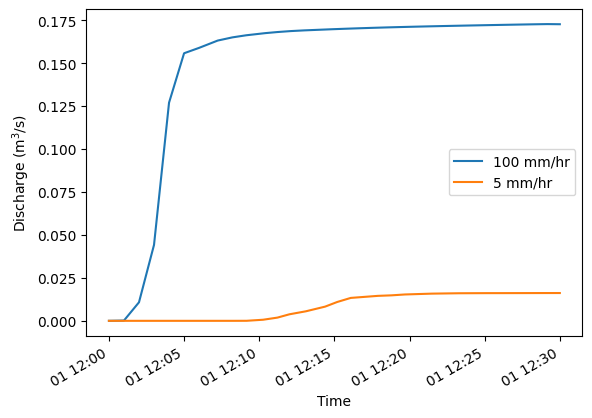

In [8]:
# Plot the new results

res_new = Res1D("data/my_simulationBaseDefault_Network_HD.res1d")
ax = res_new.reaches["Link_3"].Discharge.plot()
res.reaches["Link_3"].Discharge.plot(ax=ax)
ax.legend(["100 mm/hr", "5 mm/hr"]);

In [9]:
# Check full flow discharge

res.reaches['Link_3'].full_flow_discharge

0.13104861677514162

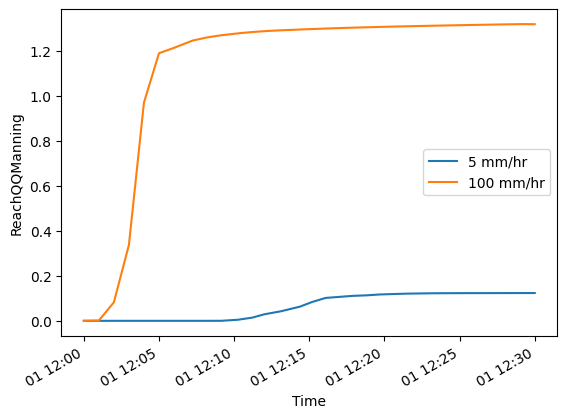

In [10]:
# Plot pipe filling
ax = res.reaches['Link_3'].ReachQQManning.plot(legend=False)
res_new.reaches['Link_3'].ReachQQManning.plot(ax=ax, legend=False)
ax.legend(["5 mm/hr", "100 mm/hr"]);

#### Run many simulations

In [11]:
# Create function for updating constant rainfall

def update_rainfall(new_rainfall):
    dta.set_value(
    table_name = 'msm_BBoundary',
    muid = 'Rainfall',
    column = 'ConstantValue',
    value = new_rainfall / 1000 / 3600 # mm/hr as m/s
    )

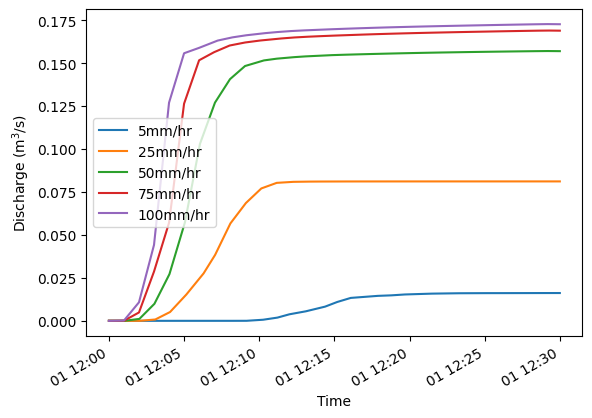

In [12]:
# Run several rainfalls, plotting the result for of each

rainfalls = [5, 25, 50, 75, 100] # mm/hr

ax = None

for rainfall in rainfalls:
    update_rainfall(rainfall)
    engine.run()
    res = Res1D("data/my_simulationBaseDefault_Network_HD.res1d")
    ax = res.reaches["Link_3"].Discharge.plot(ax=ax)

ax.legend([f"{rainfall}mm/hr" for rainfall in rainfalls])

#### Update pipe diameters

In [13]:
# Update pipe diameters

links = ['Link_1', 'Link_2', 'Link_3']
for link in links:
    dta.set_value(
        table_name = 'msm_Link',
        column = 'Diameter',
        muid = link,
        value = 0.6 # in meters, originally 0.3m
    )

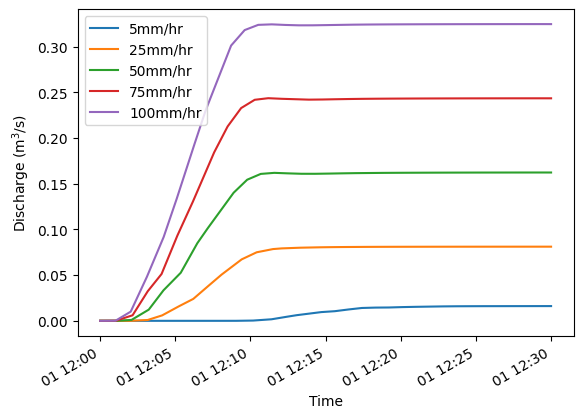

In [14]:
# Run same simulations and plots as above

rainfalls = [5, 25, 50, 75, 100]

ax = None

for rainfall in rainfalls:
    update_rainfall(rainfall)
    engine.run()
    res = Res1D("data/my_simulationBaseDefault_Network_HD.res1d")
    ax = res.reaches["Link_3"].Discharge.plot(ax=ax)

ax.legend([f"{rainfall}mm/hr" for rainfall in rainfalls]);

In [15]:
# Check full flow discharge

res.reaches['Link_3'].full_flow_discharge

0.8321068485113488

#### Clean up

In [16]:
# Reset database to original state

update_rainfall(5)
links = ['Link_1', 'Link_2', 'Link_3']
for link in links:
    dta.set_value(
        table_name = 'msm_Link',
        muid = link,
        column = 'Diameter',
        value = 0.3 # in meters, originally 0.3m
    )